In [1]:
from src import UDP_RX, SlidingBook, MACChecker
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import json
import socket
import struct
import pickle


#### parameters that needs to be exhanged between the sender and the receiver #####
IP = "0.0.0.0"
PORT = 23422
#####################################################



OFFSET = 0

# Getting the Parameters from the sender and Calculating the offset

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((IP, PORT))
    s.listen()
    conn, addr = s.accept()
    with conn:
        print('Connected by', addr)
        data1 = conn.recv(4096)
        data2 = conn.recv(1024)
        OFFSET = struct.unpack('d',data2)[0] - time.time()
        conn.sendall(b"ok")
        conn.close()

param = json.loads(data1.decode('utf-8'))
param['OFFSET'] = OFFSET
print(f"OFFSET: {OFFSET}")




total_avg_verification = []
goodput_total = []
total_latency = []
framecnt_total = []

cnt = 0
framecnt = 0
start_frame_cnt = time.time()
start = time.time()

while True:

    buffer =  SlidingBook(num_pages=100, page_size=len(param['X']))
    page_processor = MACChecker(X = param['X'], Y = param['Y'], secret_key=param['KEY'].encode(), digestmod=param['DIGESTMOD'])
    udp_rx = UDP_RX(IP= IP, PORT= PORT, buffer=buffer, page_processor= page_processor, Payload_Size_Byte=param['PAYLOAD_SIZE_BYTE'])

    msg, verification_count, latency, goodput = udp_rx.receive()
    total_avg_verification.append(np.average(verification_count))
    total_latency.append(np.average(latency))
    goodput_total.append(goodput)


    if msg is not None and len(msg) > 0:  # Ensure rec is not None and has valid data
        nparr = np.frombuffer(msg, np.uint8)
        
        if nparr is not None and len(nparr) > 0:  # Check if nparr is valid
            try:
                frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                
                if frame is not None:  # Ensure that the frame is successfully decoded
                    cv2.imshow('Received Video', frame)
                    framecnt += 1
                    if time.time() - start_frame_cnt > 1:
                        framecnt_total.append(framecnt)
                        start_frame_cnt = time.time()
                        print(f"{framecnt} fps")
                        framecnt = 0
                        
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    # print("Failed to decode frame.")
                    pass
            except Exception as e:
                # print(f"Error decoding frame: {e}")
                pass
        else:
            # print("Empty or invalid buffer received.")
            pass
    else:
        # print("Received an empty or invalid page.")
        pass

    if cnt % 100 == 0:
        print(f"avg_verification: {np.average(total_avg_verification)}, latency: {np.average(total_latency)}")
    cnt += 1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if time.time() - start > param['DURATION']:
        break
cv2.destroyAllWindows()

## saving the parameters and the results as a json file

results = {
    "avg_verification": total_avg_verification,
    "latency": total_latency,
    "goodput": goodput_total,
    "frame_rate": framecnt_total,
    "param": param
}   

# read a pickle file to get the previous results

try:
    with open("results.pkl", 'rb') as f:
        results = pickle.load(f)
        experiment_nr = len(results)
        results[experiment_nr]=results
except:
    # create a new file
    results = {0:results}
    
with open("results.pkl", 'wb') as f:
    pickle.dump(results, f)


Connected by ('127.0.0.1', 38812)
OFFSET: -0.0001628398895263672


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


avg_verification: 1.1468253968253967, latency: 18.539365860239254


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


3 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


6 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


4 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


5 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


6 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 3524 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


4 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


5 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


3 fps
avg_verification: 1.1813580283154366, latency: 17.546136791747127


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


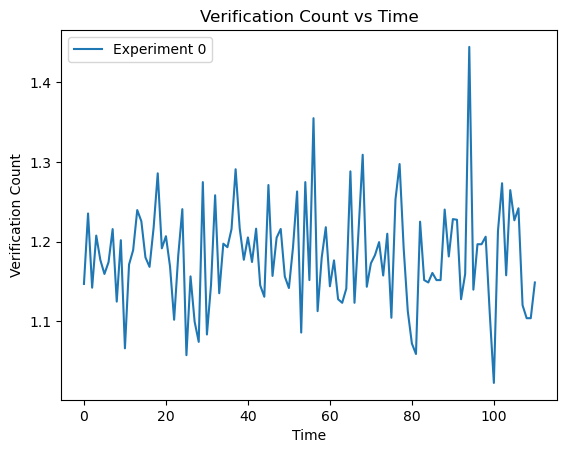

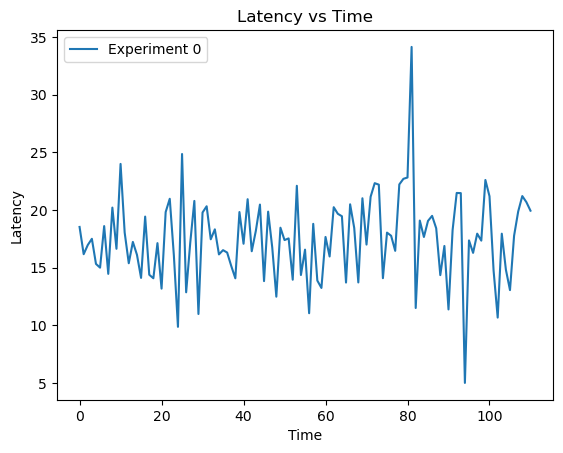

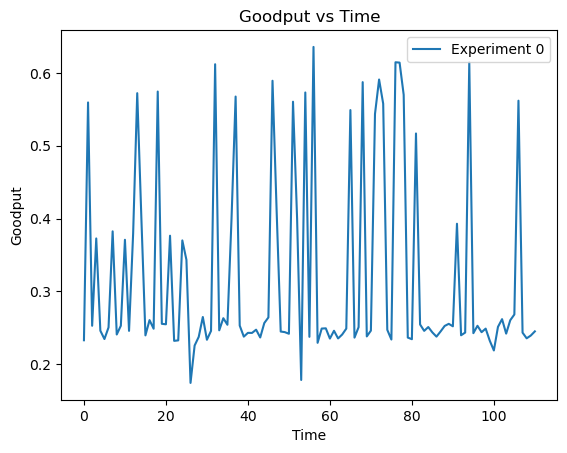

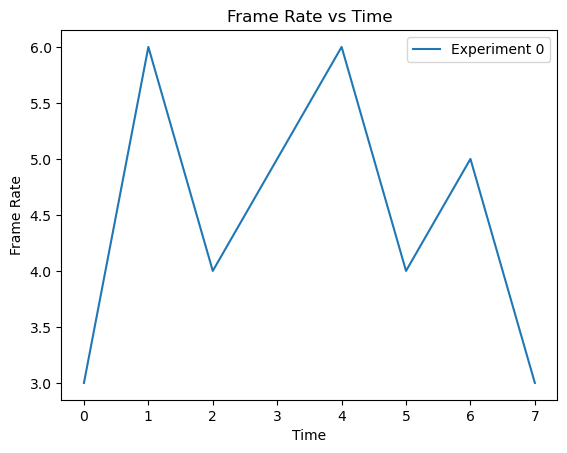

{'X': [[1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1]], 'Y': [[0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], 

In [5]:
# opening the pickle file and plotting the results
with open("results.pkl", 'rb') as f:
    results = pickle.load(f)
    for i in range(len(results)):
        plt.plot(results[i]['avg_verification'], label=f"Experiment {i}")
        plt.xlabel('Time')
        plt.ylabel('Verification Count')
        plt.title('Verification Count vs Time')
        plt.legend()
        plt.show()

        plt.plot(results[i]['latency'], label=f"Experiment {i}")
        plt.xlabel('Time')
        plt.ylabel('Latency')
        plt.title('Latency vs Time')
        plt.legend()
        plt.show()

        plt.plot(results[i]['goodput'], label=f"Experiment {i}")
        plt.xlabel('Time')
        plt.ylabel('Goodput')
        plt.title('Goodput vs Time')
        plt.legend()
        plt.show()

        plt.plot(results[i]['frame_rate'], label=f"Experiment {i}")
        plt.xlabel('Time')
        plt.ylabel('Frame Rate')
        plt.title('Frame Rate vs Time')
        plt.legend()
        plt.show()
    print(results[0]['param'])

In [3]:
print(np.average(goodput_total[goodput_total != 0]), np.average(goodput_total))

x = latency[latency != 0]+OFFSET
print(np.average(x))

0.3186537194904405 0.3186537194904405
0.00037750932905409066
